In [1]:
import numpy as np
import pandas as pd

device="cuda"
# Load the data
data = pd.read_csv('/home/nikita21546/IR/Ass4_Jeremiah/new/Reviews.csv')

In [2]:
print(len(data))
# ṭake only the Text and the Summary columns and 100 columns after dropping nan values
data = data[['Text', 'Summary']].dropna()
# save this to a new file
data.to_csv('reviews_small.csv', index=False)
data = data[:5000]
# create a column called "Training" witb df['training'] = df['Text'] + 'TL;DR' + df['Summary']  format
data['Training'] = data['Text'] + 'TL;DR' + data['Summary']
data.head()

# create a validation split
val=data.sample(frac=0.2,random_state=2000)


568454


,Text,Summary,Training
0,I have bought several of the Vitality canned d...,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,This is a confection that has been around a fe...,"""Delight"" says it all",This is a confection that has been around a fe...
3,If you are looking for the secret ingredient i...,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy at a great price. There was a wid...,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:

import re

def preprocess(text):
    text = re.sub(r'<[^<]+?>', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\d', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

data['Training'] = data['Training'].apply(preprocess)
val['Training'] = val['Training'].apply(preprocess)
val["Text"]=val["Text"].apply(preprocess)
data.head()

In [3]:
import torch
from torch.utils.data import Dataset
from transformers import GPT2Tokenizer

class CustomDataset(Dataset):
    def __init__(self, tokenizer, reviews, max_len):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.reviews = reviews
        self.result = []

        for review in self.reviews:
            # Encode the text using tokenizer.encode(), ensuring the output is in PyTorch tensors
            tokenized = self.tokenizer.encode(review, return_tensors='pt').squeeze(0)  # Remove batch dimension

            # Truncate or pad the tokenized tensor to max_len
            padded = self.pad_truncate(tokenized)

            # Store the padded result
            self.result.append(padded)

    def __len__(self):
        return len(self.result)

    def __getitem__(self, idx):
        return self.result[idx]

    def pad_truncate(self, tokens):
        if len(tokens) < self.max_len:
            # Pad with eos_token_id if shorter than max_len
            padded = torch.cat([tokens, torch.tensor([self.tokenizer.eos_token_id] * (self.max_len - len(tokens)))])
        else:
            # Truncate and append eos_token_id if longer than max_len
            padded = tokens[:self.max_len - 1]
            padded = torch.cat([padded, torch.tensor([self.tokenizer.eos_token_id])])
        return padded




/home/nikita21546/.local/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import transformers
from transformers import GPT2Tokenizer
from torch.utils.data import DataLoader

# Load the GPT2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Create a dataset object
dataset = CustomDataset(tokenizer, data['Training'], 100)

# Create a DataLoader object
data_loader = DataLoader(dataset, batch_size=2, shuffle=True)

val_dataset = CustomDataset(tokenizer, val['Training'], 100)

Token indices sequence length is longer than the specified maximum sequence length for this model (1429 > 1024). Running this sequence through the model will result in indexing errors


In [5]:
train_losses = []
val_losses = []

def train(model, optimizer, dl, epochs,val_dl):    
    for epoch in range(epochs):
        for idx, batch in enumerate(dl):
            with torch.set_grad_enabled(True):
                optimizer.zero_grad()
                batch = batch.to('cuda')
                output = model(batch, labels=batch)
                loss = output[0]
                loss.backward()
                train_losses.append(loss.item())
                optimizer.step()
                if idx % 50 == 0:
                    print(f'Epoch: {epoch}, Loss:  {loss.item()}')
            torch.cuda.empty_cache()
    # do validation
    model.eval()
    for idx, batch in enumerate(val_dl):
        with torch.set_grad_enabled(False):
            batch = batch.to('cuda')
            output = model(batch, labels=batch)
            loss = output[0]
            val_losses.append(loss.item())
            print(f'Validation Loss: {loss.item()}')
            

In [6]:
def build_model():
    from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
    from torch import cuda
    import torch
    from torch.utils.data import Dataset, DataLoader
    from transformers import AutoModelWithLMHead
    max_length = 100
    parameters={
        "BATCH_SIZE":32,          
        "EPOCHS":10,              
        "LEARNING_RATE":3e-4,          
        "MAX_TARGET_TEXT_LENGTH":max_length
    }

    #log the parameters
    print(parameters)

    # Get the tokenizer:
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
  
    # Load pretrained model from Hugging face
    model = AutoModelWithLMHead.from_pretrained("gpt2")
    device = 'cuda' if cuda.is_available() else 'cpu'
    model.to(device)

    optimizer = torch.optim.AdamW(params = model.parameters(), lr=parameters['LEARNING_RATE'])
    dataloader = DataLoader(dataset, batch_size=parameters['BATCH_SIZE'], shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=parameters['BATCH_SIZE'], shuffle=True)
    train(model, optimizer, dataloader, epochs=parameters['EPOCHS'],val_dl=val_dataloader)
    
    return model


In [7]:
model = build_model()

# save the model
model.save_pretrained('gpt2_model')
tokenizer.save_pretrained('gpt2_model')



{'BATCH_SIZE': 32, 'EPOCHS': 10, 'LEARNING_RATE': 0.0003, 'MAX_TARGET_TEXT_LENGTH': 100}


/home/nikita21546/.local/lib/python3.7/site-packages/transformers/models/auto/modeling_auto.py:1366: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Epoch: 0, Loss:  6.769970417022705
Epoch: 0, Loss:  2.8514506816864014
Epoch: 0, Loss:  2.412221908569336
Epoch: 0, Loss:  2.670905113220215
Epoch: 1, Loss:  2.049341917037964
Epoch: 1, Loss:  2.2281599044799805
Epoch: 1, Loss:  2.3654696941375732
Epoch: 1, Loss:  1.848322868347168
Epoch: 2, Loss:  1.5142971277236938
Epoch: 2, Loss:  1.5954290628433228
Epoch: 2, Loss:  1.7853630781173706
Epoch: 2, Loss:  1.5172394514083862
Epoch: 3, Loss:  1.189958095550537
Epoch: 3, Loss:  1.3111904859542847
Epoch: 3, Loss:  1.369122862815857
Epoch: 3, Loss:  1.3816734552383423
Epoch: 4, Loss:  0.6413061022758484
Epoch: 4, Loss:  0.9300592541694641
Epoch: 4, Loss:  0.9475065469741821
Epoch: 4, Loss:  0.8900873064994812
Epoch: 5, Loss:  0.5060114860534668
Epoch: 5, Loss:  0.5465066432952881
Epoch: 5, Loss:  0.5252728462219238
Epoch: 5, Loss:  0.4944131374359131
Epoch: 6, Loss:  0.27152538299560547
Epoch: 6, Loss:  0.25393417477607727
Epoch: 6, Loss:  0.3233127295970917
Epoch: 6, Loss:  0.30408665537834

('gpt2_model/tokenizer_config.json',
 'gpt2_model/special_tokens_map.json',
 'gpt2_model/vocab.json',
 'gpt2_model/merges.txt',
 'gpt2_model/added_tokens.json')

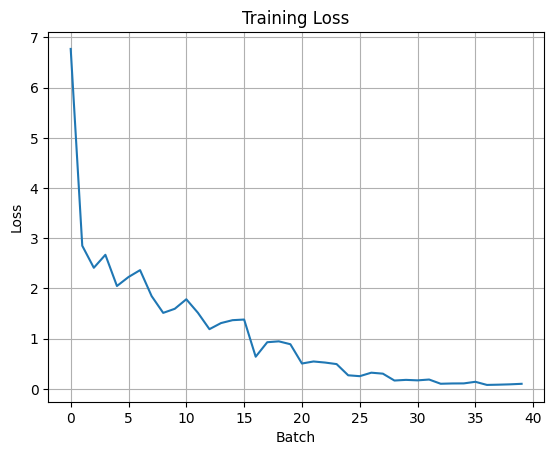

In [2]:
# Epoch: 0, Loss:  6.769970417022705
# Epoch: 0, Loss:  2.8514506816864014
# Epoch: 0, Loss:  2.412221908569336
# Epoch: 0, Loss:  2.670905113220215
# Epoch: 1, Loss:  2.049341917037964
# Epoch: 1, Loss:  2.2281599044799805
# Epoch: 1, Loss:  2.3654696941375732
# Epoch: 1, Loss:  1.848322868347168
# Epoch: 2, Loss:  1.5142971277236938
# Epoch: 2, Loss:  1.5954290628433228
# Epoch: 2, Loss:  1.7853630781173706
# Epoch: 2, Loss:  1.5172394514083862
# Epoch: 3, Loss:  1.189958095550537
# Epoch: 3, Loss:  1.3111904859542847
# Epoch: 3, Loss:  1.369122862815857
# Epoch: 3, Loss:  1.3816734552383423
# Epoch: 4, Loss:  0.6413061022758484
# Epoch: 4, Loss:  0.9300592541694641
# Epoch: 4, Loss:  0.9475065469741821
# Epoch: 4, Loss:  0.8900873064994812
# Epoch: 5, Loss:  0.5060114860534668
# Epoch: 5, Loss:  0.5465066432952881
# Epoch: 5, Loss:  0.5252728462219238
# Epoch: 5, Loss:  0.4944131374359131
# Epoch: 6, Loss:  0.27152538299560547
# Epoch: 6, Loss:  0.25393417477607727
# Epoch: 6, Loss:  0.3233127295970917
# Epoch: 6, Loss:  0.3040866553783417
# Epoch: 7, Loss:  0.16717247664928436
# Epoch: 7, Loss:  0.18034347891807556
# Epoch: 7, Loss:  0.1705045849084854
# Epoch: 7, Loss:  0.18717877566814423
# Epoch: 8, Loss:  0.10309258848428726
# Epoch: 8, Loss:  0.10880570113658905
# Epoch: 8, Loss:  0.1100982204079628
# Epoch: 8, Loss:  0.1418929100036621
# Epoch: 9, Loss:  0.07979709655046463
# Epoch: 9, Loss:  0.08469640463590622
# Epoch: 9, Loss:  0.09140437841415405
# Epoch: 9, Loss:  0.10192880779504776

# graph these loss values
import matplotlib.pyplot as plt
losses=[6.769970417022705,2.8514506816864014,2.412221908569336,2.670905113220215,2.049341917037964,2.2281599044799805,2.3654696941375732,1.848322868347168,1.5142971277236938,1.5954290628433228,1.7853630781173706,1.5172394514083862,1.189958095550537,1.3111904859542847,1.369122862815857,1.3816734552383423,0.6413061022758484,0.9300592541694641,0.9475065469741821,0.8900873064994812,0.5060114860534668,0.5465066432952881,0.5252728462219238,0.4944131374359131,0.27152538299560547,0.25393417477607727,0.3233127295970917,0.3040866553783417,0.16717247664928436,0.18034347891807556,0.1705045849084854,0.18717877566814423,0.10309258848428726,0.10880570113658905,0.1100982204079628,0.1418929100036621,0.07979709655046463,0.08469640463590622,0.09140437841415405,0.10192880779504776]

plt.plot(losses)
plt.title('Training Loss')
plt.grid()
# save the graph
plt.savefig('training_loss.png')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()



In [ ]:
# graph the losses
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)

In [8]:
#  save model using pickle
import pickle
with open('model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# save tokenizer using pickle
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

    

In [9]:
def topk_reviews(probs, n=9):
    # The scores are initially assessed using softmax to convert to probabilities
    probs = torch.softmax(probs, dim= -1)
    
    # PyTorch has its own topk method, which we use here
    tokensProb, topIx = torch.topk(probs, k=n)
    
    # The new selection pool of 9 eligible choices is normalized
    tokensProb = tokensProb / torch.sum(tokensProb)

    # Send to CPU for numpy handling and run inference
    tokensProb = tokensProb.cpu().detach().numpy()

    # Make a random choice from the pool based on the new prob distribution
    choice = np.random.choice(n, 1, p = tokensProb)
    tokenId = topIx[choice][0]

    return int(tokenId)


In [10]:
def topk_reviews(probs, n=9):
    # The scores are initially assessed using softmax to convert to probabilities
    probs = torch.softmax(probs, dim= -1)
    
    # PyTorch has its own topk method, which we use here
    tokensProb, topIx = torch.topk(probs, k=n)
    
    # The new selection pool of 9 eligible choices is normalized
    tokensProb = tokensProb / torch.sum(tokensProb)

    # Send to CPU for numpy handling and run inference
    tokensProb = tokensProb.cpu().detach().numpy()

    # Make a random choice from the pool based on the new prob distribution
    choice = np.random.choice(n, 1, p = tokensProb)
    tokenId = topIx[choice][0]

    return int(tokenId)


In [11]:
def model_infer(model, tokenizer, review, max_length=15):
    device="cuda"
    # Preprocess the init token (task designator)
    review_encoded = tokenizer.encode(review)
    result = review_encoded
    initial_input = torch.tensor(review_encoded).unsqueeze(0).to('cuda')

    with torch.set_grad_enabled(False):
        # Feed the init token to the model
        output = model(initial_input)

        # Flatten the logits at the final time step
        logits = output.logits[0,-1]

        # Make a top-k choice and append to the result
        result.append(topk(logits))

        # For max_length times:
        for _ in range(max_length):
            # Feed the current sequence to the model and make a choice
            input = torch.tensor(result).unsqueeze(0).to(device)
            output = model(input)
            logits = output.logits[0,-1]
            res_id = topk(logits)

            # If the chosen token is EOS, return the result
            if res_id == tokenizer.eos_token_id:
                return tokenizer.decode(result)
            else: # Append to the sequence 
                result.append(res_id)
    
    # IF no EOS is generated, return after the max_len
    return tokenizer.decode(result)


In [12]:
def topk(probs, n=9):
    # The scores are initially assessed using softmax to convert to probabilities
    probs = torch.softmax(probs, dim= -1)
    
    # PyTorch has its own topk method, which we use here
    tokensProb, topIx = torch.topk(probs, k=n)
    
    # The new selection pool of 9 eligible choices is normalized
    tokensProb = tokensProb / torch.sum(tokensProb)

    # Send to CPU for numpy handling and run inference
    tokensProb = tokensProb.cpu().detach().numpy()

    # Make a random choice from the pool based on the new prob distribution
    choice = np.random.choice(n, 1, p = tokensProb)
    tokenId = topIx[choice][0]

    return int(tokenId)

In [20]:
# load review.csv and take only the Text and Summary columns
data = pd.read_csv('/home/nikita21546/IR/Ass4_Jeremiah/new/Reviews.csv')
data = data[['Text', 'Summary']].dropna()
reviews=data
reviews = reviews[['Text', 'Summary']]
reviews.head()
reviews=reviews[8000:9000]
reviews.reset_index(drop=True, inplace=True)
# preprocess 
reviews['Text'] = reviews['Text'].apply(preprocess)


# reset index
reviews.reset_index(drop=True, inplace=True)
# predict summaries for 100 samples and find rouge score against the initial summary  , also while predicting use just the Text column

# make a df to save all scores and predictions
dfrouge_scores = pd.DataFrame(columns=['Text', 'Summary', 'Predictions', 'Rouge Score'])
predictions = []
rouge_scores=[]
Summary=[]
Text=[]

def rouge_score(pred, target):
    from rouge_score import rouge_scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = scorer.score(pred, target)
    return scores

def predict_summaries(reviews, model, tokenizer, n=3):
    samples = [review.split('TL;DR')[0] for review in list(reviews['Text'])]
    for i , review in enumerate(samples):
        print(i)
        #truncate the review to 30 words
        review = ' '.join(review.split()[:30])

        original_summary = reviews['Summary'][i]
        summaries = set()
        print(review)
        while len(summaries) < n:
            summary = model_infer(model, tokenizer, review + "TL;DR").split("TL;DR")[1].strip()
            if summary not in summaries:
                summaries.add(summary)
        # calculate best summary based on rouge score
        best_summary = max(summaries, key=lambda x: rouge_score(x, review)['rouge1'].fmeasure)
        predictions.append(best_summary)

        # calculate rouge score for the best summary against the orignal summary
        

        # rouge_scores.append(rouge_score(best_summary, review)
        rouge_scores.append(rouge_score(best_summary, original_summary))

        print("Summaries: "+ str(summaries) +"\n")
        print("Rouge Score: "+ str(rouge_score(list(summaries)[0], review)) +"\n")

  
    return predictions
        

predict_summaries(reviews, model, tokenizer, n=3)

# final rouge i.e average of all rouge scores
rouge_scores = [rouge_score(pred, target) for pred, target in zip(predictions, reviews['Summary'])]
final_rouge = np.mean([score['rouge1'].fmeasure for score in rouge_scores])
print(f'Final Rouge Score: {final_rouge}')
dfrouge_scores['Text'] = reviews['Text']
dfrouge_scores['Summary'] = reviews['Summary']
dfrouge_scores['Predictions'] = predictions
dfrouge_scores['Rouge_Score'] = rouge_scores


# save the results into a file
dfrouge_scores.to_csv('rouge_scores.csv', index=False)




0
This is a great marinade for any kind of meat. I use it also in stir-fry or fried rice receipes.<a href="http://www.amazon.com/gp/product/B004TGWCBQ">Garlic Sesame Marinade & Glaze Sauce</a>
Summaries: {'Yum!', 'Yum', 'Organic marinade'}

Rouge Score: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}

1
I had this cheese during the summer on a hiking trip through the French Alps. We were able to go to a small producer and watch its preparation. It is
Summaries: {'Great cheese', 'Great product', 'It is cheese cheese'}

Rouge Score: {'rouge1': Score(precision=0.03333333333333333, recall=0.5, fmeasure=0.0625), 'rougeL': Score(precision=0.03333333333333333, recall=0.5, fmeasure=0.0625)}

2
WE LOVE JAMAICAN ME CRAZY coffee!!! It's smooth and rich with a hint of vanilla and caramel. This is whole bean, so you do have to have a coffee grinder,
Summaries: {'GREAT', 'great unique flavor', 'THE BEST!'}

Rouge Score: {'rouge1': 

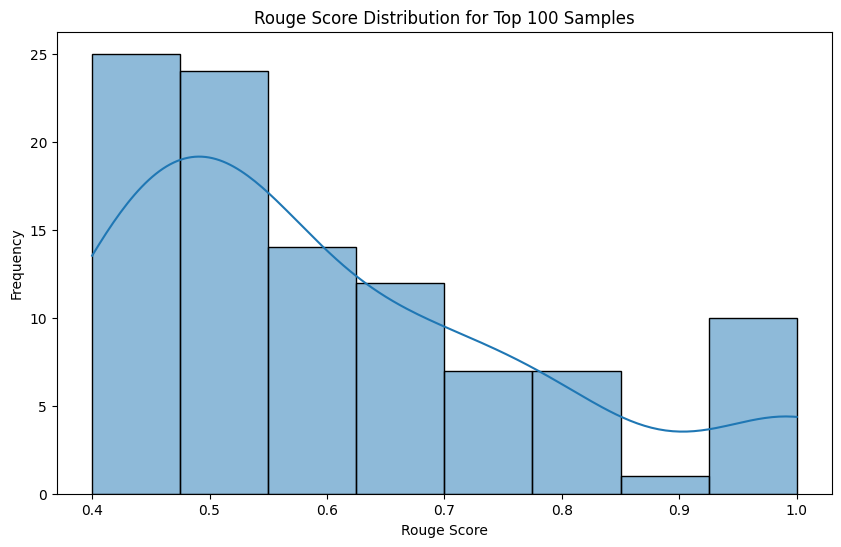

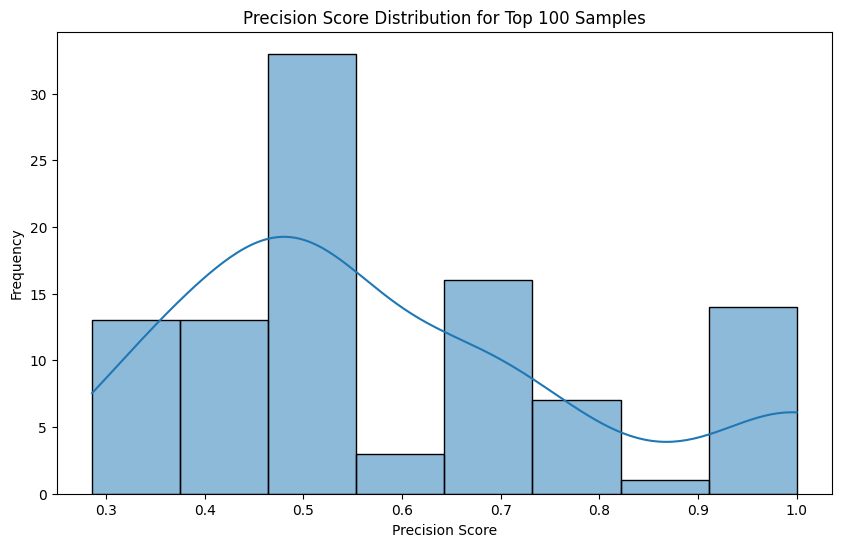

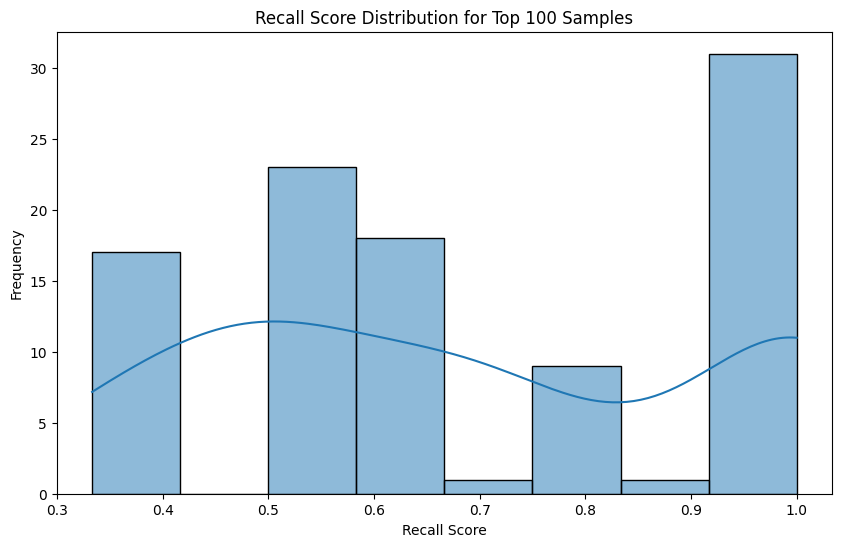

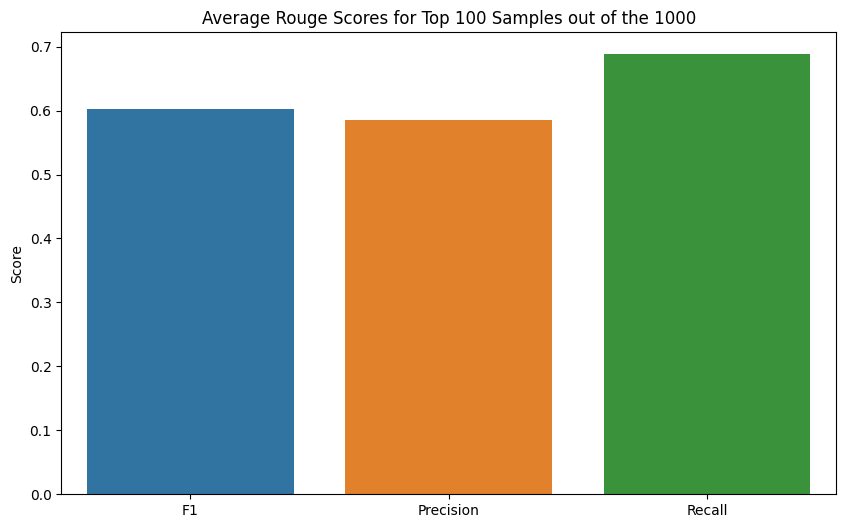

In [42]:
dfrouge_scores['Rouge_Score'] = rouge_scores


# save the results into a file
dfrouge_scores.to_csv('rouge_scores.csv', index=False)
# process rouge scores column to just  a f1 measure score
dfrouge_scores['F1_score'] = dfrouge_scores['Rouge_Score'].apply(lambda x: x['rouge1'].fmeasure)
#  save recall and precision scores in other columns
dfrouge_scores['Recall'] = dfrouge_scores['Rouge_Score'].apply(lambda x: x['rouge1'].recall)
dfrouge_scores['Precision'] = dfrouge_scores['Rouge_Score'].apply(lambda x: x['rouge1'].precision)

dfrouge_scores.to_csv('rouge_scores.csv', index=False)

#  take top 100 rouge samples and graph statistics for them  using f1 measure column into a  new df
top_100 = dfrouge_scores.sort_values(by='F1_score', ascending=False).head(100)

# graph all the scores for the top 100 samples
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(top_100['F1_score'], kde=True)
plt.title('Rouge Score Distribution for Top 100 Samples')
plt.xlabel('Rouge Score')
# plot the precision and recall scores

plt.ylabel('Frequency')
# save the plot
plt.savefig('rouge_score_distribution.png')

plt.show()


#  show the graphs for precision and recall
plt.figure(figsize=(10, 6))
sns.histplot(top_100['Precision'], kde=True)
plt.title('Precision Score Distribution for Top 100 Samples')
plt.xlabel('Precision Score')
plt.ylabel('Frequency')
plt.savefig('precision_score_distribution.png')
plt.show()
# show the recall score distribution
plt.figure(figsize=(10, 6))
sns.histplot(top_100['Recall'], kde=True)
plt.title('Recall Score Distribution for Top 100 Samples')
plt.xlabel('Recall Score')
plt.ylabel('Frequency')
plt.savefig('recall_score_distribution.png')
plt.show()

# compare the averages using graph
plt.figure(figsize=(10, 6))
sns.barplot(x=['F1', 'Precision', 'Recall'], y=[top_100['F1_score'].mean(), top_100['Precision'].mean(), top_100['Recall'].mean()])
plt.title('Average Rouge Scores for Top 100 Samples out of the 1000')
plt.ylabel('Score')
plt.savefig('average_rouge_scores.png')

plt.show()


# 

In [43]:
# print rouge statistics for the top 100 samples
print(f'Average F1 Score: {top_100["F1_score"].mean()}')
print(f'Average Precision Score: {top_100["Precision"].mean()}')

print(f'Average Recall Score: {top_100["Recall"].mean()}')
print(f'Minimum F1 Score: {top_100["F1_score"].min()}')
print(f'Maximum F1 Score: {top_100["F1_score"].max()}')

print(f'Minimum Precision Score: {top_100["Precision"].min()}')
print(f'Maximum Precision Score: {top_100["Precision"].max()}')

print(f'Minimum Recall Score: {top_100["Recall"].min()}')
print(f'Maximum Recall Score: {top_100["Recall"].max()}')

# save the top 100 samples to a new file

Average F1 Score: 0.6031969141969141
Average Precision Score: 0.5859166666666666
Average Recall Score: 0.688
Minimum F1 Score: 0.4
Maximum F1 Score: 1.0
Minimum Precision Score: 0.2857142857142857
Maximum Precision Score: 1.0
Minimum Recall Score: 0.3333333333333333
Maximum Recall Score: 1.0


In [ ]:
# #  load the model
# import pickle
# with open('model.pkl', 'rb') as model_file:
#     model = pickle.load(model_file)

# # load the tokenizer
# with open('tokenizer.pkl', 'rb') as tokenizer_file:
#     tokenizer = pickle.load(tokenizer_file)

# # import all the necessary libraries
# import pandas as pd
# import numpy as np
# import torch
# from torch.utils.data import Dataset
# from transformers import GPT2Tokenizer

# # Load the data
# data = pd.read_csv('new_data.csv')

# # take only the Text and Summary columns
# data = data[['Text', 'Summary']].dropna()
# # preprocess the data
# data['Text'] = data['Text'].apply(preprocess)
# data['Summary'] = data['Summary'].apply(preprocess)

# #  predict complete summaries and show the F1 score

# # make a df to save all scores and predictions
# dfrouge_scores2 = pd.DataFrame(columns=['Text', 'Summary', 'Predictions', 'Rouge Score'])
# predictions = []
# rouge_scores = []

# def predict_summaries(reviews, model, tokenizer, n=3):
#     samples = [review.split('TL;DR')[0] for review in list(reviews['Text'])]
#     for i , review in enumerate(samples):
#         #truncate the review to 30 words
#         review = ' '.join(review.split()[:30])

#         original_summary = reviews['Summary'][i]
#         summaries = set()
#         while len(summaries) < n:
#             summary = model_infer(model, tokenizer, review + "TL;DR").split("TL;DR")[1].strip()
#             if summary not in summaries:
#                 summaries.add(summary)
#         # calculate best summary based on rouge score
#         best_summary = max(summaries, key=lambda x: rouge_score(x, review)['rouge1'].fmeasure)
#         predictions.append(best_summary)

#         # calculate rouge score for the best summary against the orignal summary
#         rouge_scores.append(rouge_score(best_summary, original_summary))

#     return predictions

# predict_summaries(data, model, tokenizer, n=3)

# # final rouge i.e average of all rouge scores
# rouge_scores = [rouge_score(pred, target) for pred, target in zip(predictions, data['Summary'])]
# final_rouge = np.mean([score['rouge1'].fmeasure for score in rouge_scores])
# print(f'Final Rouge Score: {final_rouge}')
# dfrouge_scores2['Text'] = data['Text']
# dfrouge_scores2['Summary'] = data['Summary']
# dfrouge_scores2['Predictions'] = predictions
# dfrouge_scores2['Rouge_Score'] = rouge_scores

# # save the results into a file
# dfrouge_scores2.to_csv('rouge_scores2.csv', index=False)
